## Lecture 5 notebook

Illustration of how the initialization influences the final function. SGD cannot easily escape the initial condition, and hence even a relatively large and supposedly flexible neural network might not overfit to a tiny data if we initialize is to favor solutions that make the observations unlikely.

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Define a simple univariater regression model. 

The name "GP" refers to the observation that at the limit of infinitely wide neural network this model becomes equivalent to a Gaussian process regression model.

In [3]:
class GP(nn.Module):
  def __init__(self, D_i, D_o, K, init1, init2):
      super().__init__()
      self.fc = nn.Linear(D_i, K)
      self.out = nn.Linear(K, D_o)
      nn.init.normal_(self.fc.weight, mean=0, std=init1*np.sqrt(1/K))
      nn.init.normal_(self.out.weight, mean=0, std=init2*np.sqrt(1/K))

  def forward(self, x):
      x = self.fc(x)
      x = nn.functional.tanh(x)
      x = self.out(x)
      return x


### Demonstrate the persistent effect of initialization

Experiments with four cases:
- Case 0: Smooth initialization. The data can be modelled with smooth functions
- Case 1: Non-smooth initialization. The data can be modelled with smooth functions
- Case 2: Smooth initialization. The data cannot be modelled with smooth functions
- Case 3: Non-smooth initialization. The data cannot be modelled with smooth functions

Can you change the main observations by improving the optimization? It is maybe not *impossible* to escape the initialization with SGD or variants, so perhaps you can find a solution that learns to model non-smooth data even when initializing the model to be smooth (case 2).

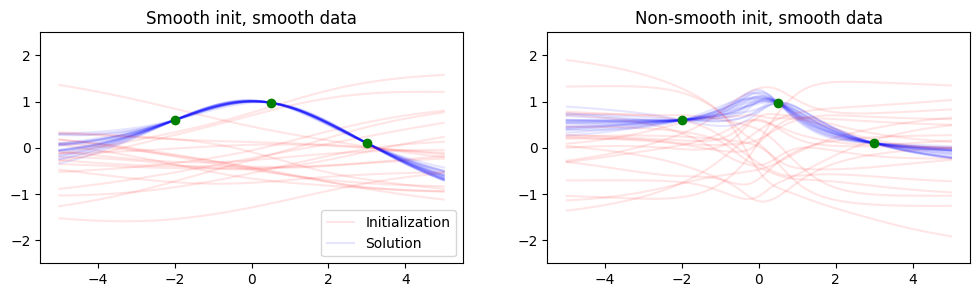

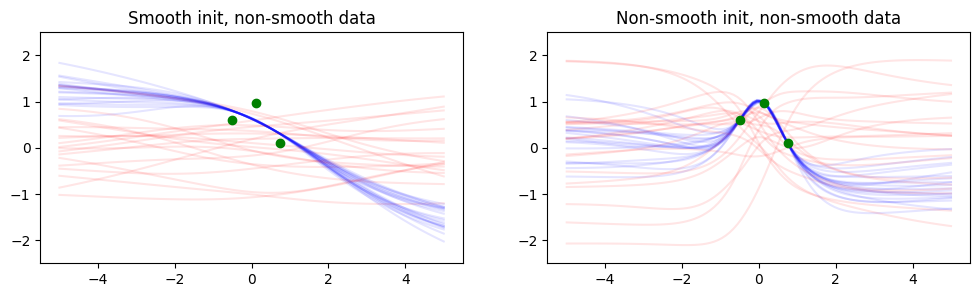

In [11]:
# Create very simple data, with just three observatons (no noise)
xobs = torch.linspace(-2,3,3).resize(3,1)
yobs = -0.1*xobs**2. + 1.

# Test grid for plotting the full functions
M = 100
xgrid = torch.linspace(-5.0,5.0,M).resize(M,1)
fig, ax = plt.subplots(1, 2, figsize=(12,3))

# Train the model with relatively wide (but not infinitely wide) network
K = 256
pcase = 0
for case in range(4):
    if case==2:
        fig, ax = plt.subplots(1, 2, figsize=(12,3))
        pcase = 0
        # Move observations closer in x space to create less smooth data
        xobs = xobs / 4.
    for rep in range(20):
        # Initialize a model
        if case==0 or case==2:
            # Smooth functions
            model = GP(1,1,K,3.0,1.0)
        else:
            # Not so smooth functions
            model = GP(1,1,K,15.0,1.0)

        # Plot the initialized model
        model.eval()
        pred = model(xgrid)
        ax[pcase].plot(xgrid.detach(), pred.detach(), 'r', alpha=0.1)
        
        # Train with three observations
        model.train()
        objective = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        for n in range(1000):
            optimizer.zero_grad()
            pred = model(xobs)
            loss = objective(yobs, pred)
            loss.backward()
            optimizer.step()

        # Plot trained model
        model.eval()
        pred = model(xgrid)
        ax[pcase].plot(xgrid.detach(), pred.detach(), 'b', alpha=0.1)
        # A bit complicate plotting code to get several runs in the same plot
        if rep==19:
            ax[pcase].plot(xobs, yobs, 'go')
            ax[pcase].set_ylim([-2.5, 2.5])
            if case==0:
                ax[pcase].legend(['Initialization','Solution'])
            if case==0:
                ax[pcase].set_title("Smooth init, smooth data")
            if case==1:
                ax[pcase].set_title("Non-smooth init, smooth data")
            if case==2:
                ax[pcase].set_title("Smooth init, non-smooth data")
            if case==3:
                ax[pcase].set_title("Non-smooth init, non-smooth data")
    pcase += 1

